In [3]:
import astropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter

In [2]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [3]:
data = data[['J2000.0', 'Type']]

In [4]:
data = data.to_pandas()

In [5]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [6]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [7]:
data.head(20000)

,coord,Type
0,002401.95 +383437.3,M
1,004243.1 +411605.0,SNI
2,002223.15 +265945.8,M
3,011529.70 +404308.4,M
4,005006.28 +353910.1,M
5,021732.96 +441817.8,M
6,001609.53 +470045.3,M
7,013936.91 +392034.7,M
8,233339.95 +484905.9,ZAND
9,005123.32 +342236.8,M


In [8]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [9]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [10]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [11]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [12]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [13]:
data.reset_index(drop=True, inplace=True)

In [14]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [15]:
data.head(20000)

,coord,Type,ra,dec
0,002401.95 +383437.3,M,6.008125,38.577028
1,004243.1 +411605.0,SNI,10.679583,41.268056
2,002223.15 +265945.8,M,5.596458,26.996056
3,011529.70 +404308.4,M,18.873750,40.719000
4,005006.28 +353910.1,M,12.526167,35.652806
5,021732.96 +441817.8,M,34.387333,44.304944
6,001609.53 +470045.3,M,4.039708,47.012583
7,013936.91 +392034.7,M,24.903792,39.342972
8,233339.95 +484905.9,ZAND,353.416458,48.818306
9,005123.32 +342236.8,M,12.847167,34.376889


In [16]:
sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

[('M', 9079),
 ('RRAB', 6149),
 ('EA', 3831),
 ('LB', 3797),
 ('EW', 3139),
 ('SR', 3047),
 ('SRB', 2640),
 ('RR', 1630),
 ('EB', 1310),
 ('BY', 1213),
 ('SRA', 1098),
 ('RRC', 1093),
 ('EA/SD', 967),
 ('UV', 966),
 ('E', 742),
 ('INB', 726),
 ('RS', 659),
 ('DCEP', 578),
 ('UVN', 549),
 ('IN', 537),
 ('DSCTC', 520),
 ('L', 511),
 ('INSB', 438),
 ('ACV', 430),
 ('DSCT', 371),
 ('nan', 369),
 ('INS', 357),
 ('INT', 323),
 ('BE', 319),
 ('UG', 265),
 ('SRD', 262),
 ('NA', 256),
 ('RR(B)', 256),
 ('EW/KW', 256),
 ('CST', 197),
 ('I', 196),
 ('EA/DM', 191),
 ('ELL', 174),
 ('CEP', 168),
 ('BCEP', 166),
 ('LPB', 150),
 ('S', 147),
 ('CWA', 143),
 ('CWB', 131),
 ('EB/KE', 131),
 ('UGSU', 124),
 ('NL', 124),
 ('GCAS', 122),
 ('ACYG', 122),
 ('IS', 121),
 ('EA/D', 120),
 ('E/SD', 112),
 ('SRS', 109),
 ('LC', 104),
 ('GDOR', 101),
 ('EA/DS', 101),
 ('RV', 95),
 ('EA/RS', 93),
 ('SRC', 93),
 ('*', 89),
 ('IB', 88),
 ('N', 88),
 ('IT', 86),
 ('INA', 85),
 ('EA/KE', 82),
 ('UGSS', 81),
 ('SXPHE', 

In [17]:
################################################################

In [18]:
for item in data.iterrows():
    print(item[1].Type)

M
SNI
M
M
M
M
M
M
ZAND
M
SRA
EA/RS
SRA
SRA
M
UGZ
M
CST
SRC
SRA
LC
M
RRAB
M
EA
M
EA
M
SRB
EA
M
SRB
LB
EA
SRB
M
SRB
LB
M
CST
SRA
SRB
EA
EA
SRD
EB
RRAB
RRAB
EA
M
M
RRAB
EB
EW
*
EB
SDOR
SDOR
S
M
M
M
M
EA
EB
M
EA
SRB
UGSS
EA
RRAB
LB
LB
SR
M
CST
M
M
LB
EB
SRB
LB
M
SRB
SRB
RRAB
EB
INSB
LB
EA
M
M
M
EA
SRA
M
UG
SR
EB
SRD
LB
DSCT
EA
LB
LB
ACV
CWA
RRAB
LB
M
SR
EB
EA
EA
SRA
LB
SR
LB
EA
SRA
LB
SRA
LB
EA
LB
RRAB
SRB
SRA
SR
CWB
EW
SRA
RRAB
LB
EB
SR
CWB
RRAB
EA
SR
RRAB
LB
E
UGSS
RRAB
CST
SR
SRA
ZAND
LB
LB
CST
EA
M
SRA
M
EW
SR
SRA
LB
ACV
LB
SR
LB
EA
M
M
UV+BY
LB
LB
RRAB
EA
EA
RRAB
UGSS
UGSU
RR
RRAB
RR
UG
RRAB
M
RRAB
EA
M
EA
UV
SRB
EA
EW
EA
LB
RRAB
DSCTC
ACV
DSCT
UV+BY
ACV
UV
RRAB
M
RRAB
EA
UV
ACV
BY
UV
RRAB
SRB
M
ACV
LB
GAL
NL
EA
EA
IA
EW
NL
UV
RRAB
UV
SR
RRAB
RRAB
EA
RRAB
QSO
EA
RRAB
RRAB
SRA
RRAB
RRAB
SR
UGZ
SR
RRAB
UG
ACV
M
RR
EA
nan
EA
LB
LB
LB
SR
M
UGSU
UG
BE
BE
BY
UGSU
EB
CST
EW
M
BE
ELL
NA
UG
IA
RRAB
EA
UG
EW
EW
EA
EB
EA
RRAB
RRAB
RRC
EW
EW
RRAB
RRAB
EW
RRAB
RRAB
EW
RRAB
RRC
EA
RRAB
RRAB
LB
RRC


SRB
SRA
LB
SR
M
CEP
LB
LB
M
RVA
LB
M
SRB
M
M
SRB
M
SRB
M
SRB
SRB
LB
EA
RVA
M
SRA
SRB
LB
M
SRD
LB
EB
DCEP
M
EA
NA+XM
NA
*
NA
M
SRB
EB
RRAB
EA
SRB
SR
M
M
EA
M
M
M
M
SRB
SRD
SRA
M
RRAB
M
LB
M
RRAB
EA
EA
M
M
EA
SRB
M
M
M
RRAB
EB
M
SRB
SRB
EA
M
M
EA
SRB
SRB
SRB
RRAB
M
M
SRB
M
M
SRA
M
M
SRB
M
LB
M
M
SRB
M
SR
RRAB
M
SRB
M
RRAB
M
SRB
LB
EW
SRB
SRB
LB
SRB
SRB
SRB
LB
M
SRB
SRB
SRB
EB
SRB
EA
RRAB
SRB
LB
EA
RRAB
SR
SR
SR
EW
LB
LB
SRA
LB
M
M
RRAB
M
SRB
RRAB
SR
EA
SRB
M
EA
M
SRB
RRAB
LB
EA
LB
RRC
SRB
EW
EW
UGSU
M
M
RRAB
EA
SRB
LB
LB
DCEP
M
LB
LB
EA
LB
RR
RRAB
RRAB
LB
SRD
M
LB
SR
M
LB
LB
M
RRAB
LB
RRAB
SRB
EA
RV
SRA
SRB
M
EA
EA
EA
RRAB
RRAB
EA
RRC
RRAB
LB
EA
EA
UG
M
RRAB
SRB
M
M
SRB
M
RRAB
M
LB
RR
L
EW
RRAB
LB
EA
RRAB
SRB
LB
SRB
RRAB
RRC
NL
EA
EA
M
M
EA
DCEP
CWA
EW
EW
EW
EA
M
L
EA
RRC
SR
M
LB
M
M
M
M
M
SR
M
M
SR
EA
M
M
M
M
M
LB
DSCT
SRB
RR
RRAB
M
M
M
RRC
M
SRB
SRB
SRB
NB
LB
EA
SRB
M
M
M
SRB
M
M
M
LB
LB
M
SRB
LB
LB
LB
LB
M
RV
M
M
EA
M
EA
M
SRB
EA
SRB
EA
EA
EW
M
NL
LB
M
LB
EW
RRAB
DSCT
RRAB
LB
SRB
EA
M

EW
RS
IT
BY
INT
INT
BY
INT
INT
IT
BY
RRC
RS
RS
RS
RS
RRAB
RS
EB
EW
SRS
EW
EW
EW
DSCTC
SRB
EW
RRAB
EW
EB
EB
EW
EW
EB
EW
EW
RS
EW
EW
EW
EW
EB
RR(B)
RR(B)
RR(B)
RR(B)
DSCT
EW
RR(B)
EW
RR(B)
EW
ACV
EB
M
SR
NB+EA
M
M
M
M
DCEP
SR
M
SR
DCEP
M
SRB
IT
DCEP
EA
EA
UGSS
M
INT
LB
M
EB
DCEP
M
EA
SRB
SRB
SRB
LB
CST
RRAB
SRB
M
SRA
SRC
INT
SRB
M
SRB
M
M
CST
EA
LB
SR
M
EB
M
SR
M
DCEP
EB
M
INA
M
SRB
INA
SR
SRD
EW
SR
EA
M
EA
DCEP
DCEP
EB
M
EA
DCEP
M
M
CST
M
DCEP
M
M
SRB
EA
M
EA
EB
RRAB
M
DCEP
LB
M
M
SRB
LB
LB
LB
M
M
SRA
M
M
LB
LB
LB
M
M
LB
EA
EA
EA
EA
EA
LB
SRB
CEP(B)
EA
EA/RS
RRAB
SRB
LB
LB
E
LB
DCEP
LB
LB
LB
LB
INSA
SRB
LB
LB
LB
M
RRC
EA
M
LB
SRA
LB
M
M
SRB
LB
SRA
M
LB
LB
LB
SRB
LB
EA
EA
LB
EB
LB
EA
EB
EA
DCEP
LB
M
EA
SR
DCEP
LB
LB
SRB
DCEP
EA
LB
LB
RV
LB
IS
EA
EA
EA
LB
EA
UG
LB
LB
EA
EA
LB
EA
EA
SRB
M
EA
EA
E
INT
M
M
CWB
M
M
LB
DCEP
SRA
DCEP
EA
EB
EA
IS
CST
CST
LB
EB
LB
SRB
IS
EA
M
E/RS
EA
M
EA
UGSU
EB
M
SR
ACV
EB
EA
EA
EA
DCEP
E
E
ACV
E
SR
EA
EB
IA
DCEP
LB
EB
EA
M
EA
EA
RRAB
EA
M
LB
NL
LB
SRA
EA
SRB
D

EA
DCEP
DCEP
DCEP
M
M
SRB
EA
EA
M
EA
M
EA
DCEP
DCEP
EA
M
EA
EA
M
EB
EB
SRD
SRC
CEP
EB
CEP
SRC
DCEPS
EB
SRB
CEP
UGZ
M
EA
DCEP
EA/RS
CEP
EA
EA
RRAB
EA
EA
EA
EA
EA
EA
CEP
EA
CEP
CEP
EA
DCEP
EA
SRB
EA
EA
EA
EA
SR
M
EA
EA
EA
I
CEP
EA
SRB
SRB
EA
M
M
SRB
EA
EA
EA
SRB
M
M
LB
EW
M
EA
SRB
RRAB
SRB
CEP
M
SRB
SRB
EA
SRB
UGSU
EA
EA
EA
M
EA
DCEP
SRB
CEP
SRB
EB
SRB
EA
EA
EA
EA
EA
SRB
EA
EA
EA
M
M
M
M
SR
M
M
M
EA
EA
EA
LB
M
SRB
SRB
SRB
INA
SRB
LB
CEP(B)
EA
EA
EA
M
EA
SRB
EA
M
RR
M
M
EA
DCEP
EA
DCEP
UG
EA
GCAS+BCEP
EA
BCEP
WR
EB
SRB
SRB
BY
EA
DCEP
EA
BCEP
EA
DCEP
EA
BE
IA
BE
BE
BE
BE
SRB
BE
EA
CST
LB
DCEP
M
SRB
SRB
SRB
SRB
M
SRB
SRB
SRB
M
INA
SR
SRB
SRB
CST
EA
BCEP
BE
SXARI
UGSS
UV
DSCTC
CST
BE
EA
EA
M
IA
IA
M
EA
M
EA/RS
ELL
EW
EW
EA+LPB
EA
NL
EA
LPB
EB
SRB
EW
LPB
ACV
SRC
EA
EB
E
LB
ELL
EA
LB
SRD
SRB
LPB
ACV
SRB
BE
EA
BE
EA
ACV
SRB
SRB
BE
BE
ACYG
LB
LB
BE
BE
ACYG
EA
EA
LB
EB
SRB
LB
BE
EB
LPB
BE
CST
EA
LB
ACV
EA
SRB
ACYG
EB
ACV
EB
SRB
SR
GCAS
BE
BE
BE
DSCTC
EA
RRAB
EW
EA
EW
EA
SRB
LPB
M
M
SRB
M
ACYG
M
E

EW
EA
DSCT
DCEP
SR
LB
SR
SR
LB
SR
SR
SR
M
LB
M
SR
SR
SR
SR
LB
SRB
M
LB
SR
SR
LB
SR
SR
SR
SR
SR
SR
SR
BCEP
SR
SR
SR
LB
LB
SR
SR
SR
SR
SR
SR
SR
SR
SR
SR
SR
SR
SR
M
LB
SR
SR
SR
SR
SR
SR
SR
SR
LB
M
SR
SR
SR
LB
SR
LB
DCEP
M
SR
SR
SR
SR
EA
M
M
M
IS
SR
SR
EW
SR
EB
EA
SR
SR
SR
BY
SR
SR
EA/RS
LB
EA/RS
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BE
BY
ACVO
BY
*
M
M
SR
SR
LB
SR
DCEP
SR
SR
M
EA
nan
nan
EA
EA
GDOR
EW
LB
EB
EA
EB
GDOR
DCEP
EB
EA
DCEP
DCEP
EA
DCEPS
DCEP
EA
EA
RRAB
EW
EA
DSCTC
EA
LB
CWA
EW
EW
EA
NL
RRAB
RRC
IT
*
EB
SRB
DSCT
RRAB
SRA
EA
EA
RRAB
EA
RRC
SR
EA
LB
LB
DSCTC
EW
LB
BY
RRC
DSCTC
RRAB
EA
EA
EB
EW
EW
EA/RS
EA
EB
EA
EW
EA
RV
BE
DCEPS
DSCT
LB
EW
EW
DSCTC
EB
EA
EW
LB
DCEPS
EA
LB
LPB
DCEPS
DSCT
LB
EW
LB
RR
EW
EW
RRAB
EB
LB
EA
DCEP
DCEP
EW
CWB
EA
EA
DSCTC
EA
EW
SRB
RRAB
EA
DSCTC
EA
DSCTC
EW
EW
BCEP
DSCTC
DSCTC
DSCTC
EA
EW
BE
EA
DSCTC
EW
GDOR
GDOR
SRC
SRS
EA
EA
GDOR
EA
EB
EW
EW
EA
EA
EW
EA
EA
ELL
BCEP
EA
GDOR
BE
BE
GDOR
BE
GDOR
RRAB
ELL
LPB
DCEP
BCEP
BCEP
ELL
SRA
EA
EA
LB
EA
GCAS
EA
LB


LB
SR
SRB
LB
LB
SR
SR
LB
LB
SR
SR
SR
SRB
LB
SRB
SRB
SR
LB
L
SR
LB
LB
SR
LB
LB
SR
SR
SR
SR
LB
LB
LB
LB
LB
SR
SR
SR
SR
LB
SR
SR
LB
SR
LB
SR
SR
LB
LB
L
SR
LB
LB
LB
LB
SR
SR
SRB
LB
LB
SR
SR
LB
LB
LB
BE
SR
LB
SR
LB
LB
LB
LB
LB
LB
LB
SR
LB
SRB
LB
SR
LB
LB
LB
LB
SR
LB
LB
SRB
LB
LB
M
LB
LB
EA
EB
SRB
LB
GDOR
M
M
M
SR
M
M
N
EB
EA
SR
UG+EA
M
LB
M
M
SR
M
M
SR
SR
M
SR
SR
M
EA
SR
SR
ISA
EA
SR
FU
EA
EA
EW
EW
EA
DCEP
RRAB
EA
RRAB
EA
EB
EA
EA
EA
EA
EA
EA
EB
EW
EA
EW
EW
EA
EW
EA
RRC
EW
RRC
BY
BY
EW
BY
BY
EA
BY
BY
BY
BY
BY
BY
BY
EB
BY
EW
BY
BY
BY
BY
EW
BY
EB
EA
BY
BY
BY
EW
EW
EW
DSCT
EW
DSCTC
RRC
EW
EW
EA
LB
EA
EA
EW
EW
EW
EA
EA
CWA
EB
NA
EB
EW
EA
EW
EA
SRB
EW
EW
RRAB
EW
EW
EW
DSCT
SR
EA
BY
EW
UG
SR
EW
EW
LB
RS
EB
EB
EW
EW
EW
EB
EA
SR
EA
EW
EW
RS
EW
SR
SRB
SR
EA
EA
LB
RS
EW
EA
EW
EW
RRAB
LB
DCEP
DCEP
RRAB
EA
EB
EB
M
EW
LB
EA
SR
EW
SR
EW
ACYG
BCEP
EW
DSCT
EA
BY
LB
EA
EA
BY
EA
SR
EW
EA
EA
EA
EW
EA
EA
EW
SR
LB
EA
ELL
EA
EA
SRA
EA
DCEP
EW
LB
SR
RRAB
SRA
EB
DCEPS
EW
EA
DCEP
SRB
LB
EW
EA
SR
EW
EW
EA
BE
EA
EA
E

EA/DS
EA/SD
EA/DS
DCEP
DCEP
DCEP
EA/SD
M
M
EB/K
SXPHE
M
RRAB
SRA
CST
EA/SD
SRB
SRB
SRB
LB
EA/SD
SRB
M
SRB
SRB
CST
DCEP
M
M
M
M
nan
nan
M
M
M
SRD
SRB
LB
LB
SRC
M
SRC
nan
LB
ZAND
M
M
LC
M
M
M
M
EA/DM
M
M
EA/SD
M
M
M
M
SRB
LB
M
DCEP
M
DCEP
CST
CST
EA/SD/RS
ZAND+SR
EA/GS+ZAND
NC
M
M
M
LB
CST
CST
nan
M
M
M
EW/DW
E
SRA
LB
M
M
M
RVB
M
M
M
EW/D
EA/DM
RRAB
M
EA/SD
EA
M
M
LB
DCEPS
M
M
M
EA/SD
SR
M
EA
SRB
M
M
RV
SRB
M
UGZ+E
EA/SD
M
DCEP
M
M
SRA
M
CEP
M
LB
DCEP
UGSS
DCEP
M
M
SRA
M
M
M
M
M
SRA
M
M
EA/SD
M
SR
M
SRA
M
M
SR
M
EA/SD
DCEP
DCEP
RV
CEP
EA/SD
SRA
EB/KE
M
M
M
M
EA/SD
M
EA/SD
M
SRA
SRB
SR
M
M
EA/SD
EA/DS
M
UG
M
M
M
M
M
M
M
SRB
M
M
SR
M
SR
SRA
M
M
M
M
M
M
M
M
SRA
CW
RRAB
M
SR
CEP
M
M
M
M
EA
M
RRAB
M
EB
M
GCAS
EA/D/RS
EB/SD
M
DCEP
LC
M
M
M
EB/SD
EB
M
LB
E
M
M
EA
M
LB
M
M
M
SRA
SRA
LB
M
M
EA/SD
SR
L
EB
LB
DCEP
EA/DM
CWA
E
LB
E/KE
RRC
LB
RRAB
M
EW/KW
E
M
E
EA/DS
EW/KW
E
E/KE
LB
E/KE
E
E/SD
E/DW
E/SD
E
E
ZAND
RR
M
E/KE
LB
S
M
LB
E/SD
EA
M
EW/KW
L
RR
E
E/KE
EA/SD
E
S
EB
E/DW
CWB
LB
LB
CWA
UG
M
M
E

EA
EB
EA
EW
EW
CEP
LB
RRAB
EA
RRAB
EW
EA
EW
EA
RRAB
EA
EW
EW
EW
IN
EW
LB
SRB
EW
RS
EW
EA+UV
EB
RRAB
EA
EW
EA
EA
BY
DCEP
DCEP
EA
BY
RS
EA
EB
EW
R
NB
EW
EW
EB
EA
EW
EW
EA
BY
EW
EW
EA
LB
EA
RRC
EA
LB
EW
DSCT
EW
EW
EB
LB
BY
EB
DSCT
EA
EB
EW
EA
EA
NL
EA
EW
EW
DSCTC
DSCT
M
EW
EA/RS
GDOR
BCEP
EW
DSCT
DSCTC
RS
EB
DSCT
BY
EW
NL+ZZ
RS
M
DSCTC
EW
EW
EW
EW
EW
EW
EW
EW
BY
EW
EA
EW
EW
EW
DCEP
EA
EB
BY
EW
EW
EA
EA
EA
GDOR
EW
EW
EW
EA
EW
SR
EW
EW
EA
EW
EW
EA
RRAB
EW
EW
EW
EW
EW
EW
EB
EW
EW
EW
EA
EB
XN
EA
EW
BY
EW
EA
EW
M
RRC
DSCT
EA
LPB
EW
EW
EW
EW
EW
EW
EW
BY
EA
EW
EW
EA
RRAB
EB
EW
EW
EB
EW
EB
EA
ACV
EA
EA
EA
EW
DSCTC
EW
EA
EW
CWB
ACV
ACV
EW
SRB
EB
SRD
LB
EB
EA
EA
EW
EW
EW
EW
EW
EW
EW
EA
EW
EB
EW
EA
EW
EB
EB
EW
EW
SRA
EW
EW
EW
DCEP
EW
EW
DSCT
DSCTC
EW
EA
RRAB
SR
SRB
SRB
EW
SRB
EA+DSCTC
SRB
DSCTC
SRB
EA
SRB
SRB
DSCT
SRB
SRB
M
LB
ELL+DSCTC
SRB
LB
DSCTC
LB
SRB
EW
SRB
M
M
SRB
EW
EW
ZAND
EW
EB
EB
DSCTC
EA
SRB
EB
M
M
M
EB
SR
LB
DSCT
EB
EW
DSCTC
N
ACYG
BE
DSCT
GCAS
M
SDOR
NA
M
M
M
SRB
M
EA/SD
M
M
M
EA/SD
SR

L
EA
RRAB
EA/SD
SRB
LB
RRAB
SRB
SR
LB
RRC
L
L
LB
EA/SD
LB
SR
EB/KE
RRAB
SR
L
LB
M
M
SRA
M
LB
SR
INS
M
M
M
LB
M
RRAB
M
EA/SD
LB
EB/DM
RRC
EA/D
M
EA/D
RRC
RRAB
SR
SXPHE
EA/AR/RS
RRAB
RRAB
RRC
RRAB
CST
EW/KE
EB/SD
SR
M
M
EA/SD
L
SRB
LB
SR
M
CST
IS
SRB
LB
M
RRAB
SRA
M
CWB
L
LB
SRB
SRA
RV
RRAB
RRAB
LB
RRAB
RRAB
RRAB
RRC
M
RRAB
IS
UG
LB
SR
UG
SRA
EA/AR:/RS
RRAB
RRAB
SR
RRAB
RRAB
SRB
LB
RRAB
M
M
M
M
M
SRD
SRB
EA/SD
SR
M
LB
EB/SD
SR
M
M
M
RRAB
M
RRAB
LB
SRB
SRB
LB
LB
EA/SD
M
DSCT
EA/SD
EA/SD
SR
RRAB
SRA
RRAB
RRAB
EA/SD
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RR
LB
SRA
RRAB
RRAB
RRAB
RRAB
RRAB
EA/SD
RRAB
RRC
RR
RRAB
RRAB
EB/KE
RRAB
RRAB
RRAB
RRAB
RRAB
M
RRAB
GAL
QSO
RRAB
RRAB
RRAB
L
RRAB
RRAB
EB/KE
RR
RRAB
RRAB
IS
RRAB
RRAB
RRC
RR
EB/KW
RRC
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RR
RRAB
EA/SD
RRAB
RRAB
EW/KW
LB
RRAB
RRAB
RRAB
RRAB
EW
CST
RRAB
RRAB
RR
RRAB
RRAB
RRAB
RRAB
SRD
RRAB
ZAND
M
M
NA
RR
RRAB
LB
EA/D
ACV
SRA
RRAB
L
L
LB
LB
RRC
RRAB
SRA
RR
L
SRD
ISB
EA/SD
SRB
RRAB
RRAB
RRAB
IS
RRAB
LB
L
RRAB
UV
RRAB
EW/

M
LB
SRB
LB
SRB
SR
SRA
EA
LB
M
L
LB
M
EA/SD
EA
L
EA
EA
EA/D
LB
EW
EA/SD
EW/KW
EA/DM
L
ISB
LB
EA
ELL+RS
SRA
LB
I
LB
LB
SR
GCAS
M
EA
EB/DM
LB
ACV
LB
EA/DM
ELL
M
M
EA/SD
EA/SD
LB
EA/SD
SRB
LB
L
INA
SRB
LPB
LB
M
M
NL
SR
BY+UV
SR
M
M
M
M
M
M
SRA
I
EB
ACYG
IA
BE
EA
ACYG
LPB
EA
EA
LB
BE
LPB
ACYG
ELL
GCAS
GCAS
LB
DCEPS
LC
ELL
ACV
BE
LB
LB
LB
LB
SRD
LB
IA
BE
LC
SRA
SR
EA
M
SRA
EA
EA
SRB
EA
SR
EB
DSCTC
DSCTC
DSCT
SR
RRAB
EW
*
BY
SR
M
BY
BY
SRD
M
EA
M
SR
EA/SD
LB
EA
EA
EA
EA
EA
EW
EW
DSCTC
DSCTC
DSCTC
LB
EA
EA
LPB
BY
RRAB
BY
EB
RRAB
EB
LB
EA
SR
EW
EW
EW
DSCT
EW
EB
EA
EW
EW
EW
EW
EW
EB
DSCT
EW
DSCT
LB
EA
EA
LB
EW
SR
EA
LB
LB
EW
EB
EW
EW
EW
LB
EW
EA
EW
EW
EW
EA
LB
EW
EA
EW
EW
EW
EW
EA
EW
DSCTC
EW
EW
EW
EW
EA
RRC
EW
BY
LB
EB
BY
EW
EW
DSCTC
LB
RRC
LB
LB
RRC
EW
EA
EA
DSCT
RRC
EW
EW
EW
EW
EW
LB
BY
EA
EA
LB
EW
EW
EW
EA
EW
SRB
EA
EW
LB
DSCTC
EW
EA
LB
EA
EW
SR
EW
LB
SR
BY
DSCTC
EA
EW
EW
EW
EW
EB
DSCT
EA
EW
EB
EA
EW
BY
EA
EW
EA
EW
EA
BY
EW
EW
EA
EA
EA
EW
EW
BY
DSCTC
RRC
LB
EB
EW
EW
EA
L
EW
EW
EW
EW
EA
LB
B

RS
SR
EW
EW
EA
EW
EW
EW
EW
SR
BY
EA
BY
EW
EW
EW
EW
EW
EW
EB
EW
DSCTC
EW
BY
EW
EB
LB
BY
EB
RRC
EW
EW
EW
RRC
EA
SR
EW
RRC
L
EW
EW
DSCT
EA
EW
EW
EW
EW
EW
EW
EW
BY
EA
EA
UG
EA
BY
EW
DSCT
EW
SR
LB
EW
BY
EW
LB
LB
EA
DSCT
EW
RRC
EW
EB
RRAB
EW
RRAB
M
DSCT
SRB
EP
SRB
EW
LB
EB
EB
RRAB
SRD
RRC
EB
EW
EA
SRB
SRB
EW
EA
EA
SRB
M
EW
LB
EA
RRAB
SR
RRAB
M
EW
EW
RRAB
EB
RRC
EB
NL+EA
SRB
EW
EW
EA+ELL/RS
EA
EW
EW
EW
EW
LB
EB
EB
RRAB
RRAB
RRAB
SRB
EW
LB
SRB
EW
SRB
UG
UG
SRB
M
DSCTC
EB
SRC
BE
SRB
LB
RRAB
SRA
RR
RCB
M
RR
RR
EA/D
M
M
M
RRAB
RR
RRAB
EA
RR
RR
RR
EA
RR
EA
RR
M
RR
RR
UGSU
RR
IS
RRAB
EW/K
EA/D
RRAB
RRAB
M
EA/DM
EA
L
EA
L
EA
EA
L
SR
LB
RRC
RRAB
RRAB
EB/KE
DSCTC(B)
FKCOM
RS
SRA
RRAB
EA/SD
RRAB
UGSS
RS
SR
SR
NL
SRB
DSCT
EB
LB
EW
BY
SRB
NL+E
SRA
SRB
EA
EW
RRAB
EA
SRB
SRB
RRC
EW
BY
SR
RS
RS
ELL
M
M
SRB
M
M
M
M
SR
RRAB
CWA
M
M
SR
M
M
M
M
EA/DM
nan
RRAB
RRAB
RRAB
SR
RR
RRAB
E
RRAB
RRC
EB/AR
RR
RRC
RRAB
RRAB
RRC
RRAB
SR
RRAB
IS
EW/KW
RRAB
RRAB
RRAB
EA/DM
RRAB
RRC
RRAB
RRAB
EA
RRAB
M
RRAB
RRAB
RRAB
DSCT(B:)

M
M
nan
nan
nan
nan
M
nan
nan
M
nan
nan
M
nan
M
nan
M
E/SD
M
nan
L
nan
RR
M
nan
E/SD
L
nan
CWA
nan
nan
nan
M
M
L
SR
L
nan
nan
nan
E/SD
M
nan
S
L
nan
S
M
M
M
M
M
SR
SR
SR
nan
nan
M
S
E
nan
M
SR
nan
L
nan
nan
M
nan
SR
SR
nan
M
S
M
SR
M
M
M
M
nan
M
SR
RRC
M
nan
M
nan
M
M
RR
M
M
M
INB
nan
nan
INA
nan
M
RR
nan
nan
SR
SR
S
M
M
RR
RR
RR
RRAB
L
E/SD
M
M
RR
RR
nan
RR
RR
S
RRAB
RRAB
RRAB
RR
nan
RR
S
nan
L
nan
RR
RRAB
RR
L
M
nan
RRAB
E
RRAB
nan
RRAB
RR
nan
SR
RR
RR
M
nan
M
RR
M
L
RR
nan
RR
RR
E
RR
RR
RRAB
RR
L
RRAB
RRAB
S
L
RR
M
RRAB
nan
RRAB
nan
nan
RRAB
RR
RRC
RRAB
E/SD
RRAB
L
nan
L
nan
L
nan
nan
RR
RR
L
L
M
RRAB
nan
nan
nan
RRAB
L
RR
L
L
RR
nan
SR
nan
nan
nan
nan
RRAB
M
SR
S
S
nan
M
M
SR
RRAB
M
M
nan
nan
RRAB
SR
M
M
M
M
M
M
EB/DS
M
NL
M
M
M
M
M
L
M
L
M
M
EA/SD
IS
L
SR
M
SR
nan
M
nan
M
M
SR
SR
M
M
nan
M
RR
M
nan
M
M
RRAB
RRAB
EA
M
M
SR
LB
M
M
M
EA/SD
M
M
NL
M
SRA
SR
RRAB
M
CST
SR
M
LB
M
M
SRB
CWB
M
EA/SD
NL
nan
M
RRAB
SR
SRB
EA/SD
EA/SD
M
EA/DM
RRAB
RVA
SR
RRAB
EA/DM
M
SR
M
SR
SR
M
M
L
CWB
L
SR

NA
NA
NA
NA
NA
INT
NA
NA
RS
RRAB
RRAB
SR
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRC
RRAB
UGSU
RRAB
RRAB
RRAB
RRC
RRAB
LB
RRAB
EA
RRAB
BY
EW
RS
RRAB
SRA
M
SRA
SRA
SRA
RRAB
RRAB
DSCTC
EB
EB
M
XB
EW
EW
RRAB
EW
CEP
RRAB
EA
BY
EB
RRAB
RRAB
M
EW
EA
EB
XM
RRAB
CWB
RRAB
CWB
CWB
EA
CWB
CWB
SRB
SRB
GDOR
RRAB
DCEPS
EA
SRA
RRAB
BY
RRAB
LB
BY
EA
SRB
DSCT
BY
SRA
BY
EW
LB
SRB
EA
BY
BY
RRAB
SRB
EA/RS
BY
EW
BY
SXPHE
EW
EB
RRAB
EW
EW
EB
RRAB
EW
E+NL
EA
RRC
EW
EW
RRAB
RRC
SRB
EA
LB
RRAB
EW
BY
BY
RRAB
EW
DSCTC
DSCTC
DSCTC
DSCTC
EA
DSCTC
DSCTC
DSCTC
DSCTC
DSCTC
DSCTC
DSCTC
DSCTC
DSCTC
EA
DSCTC
DSCTC
DSCT
EA
DSCTC
LB
BCEP
EA
DSCTC
EA
DSCTC
DSCTC
EA
EW
DSCTC
LB
SR
SR
EW
SRB
SR
EW
RRC
SRB
SRB
SRB
SRB
INB
SRB
EB
LB
LB
DSCT
M
SRA
SR
EW
DSCT
UG
SRA
M
EW
EB
EW
BY
EW
BY
EW
BY
SRB
EW
EW
XND
RRC
SRB
M
SRB
E/RS
EB
SRB
M
SR
LB
EW
M
SRA
M
M
SRA
M
EW
EW
M
SR
M
M
SR
LB
M
M
SRB
EW
M
SR
LB
SR
LB
SR
SR
SRB
LB
LB
RCB
SR
SRB
M
SR
M
SR
SR
M
SR
SRB
SRB
SRB
LB
M
SR
M
M
EW
RV
LB
SR
SR
RRAB
M
M
M
SRB
RRAB
RRAB
LB
EW
M
BY
BY
BY
EW
CWB
EB
SR

UVN
UVN
SR
M
RS
EA/GS/WD
UVN
UVN
UVN
UVN
UVN
UVN
UVN
UVN
UVN
INA
UV
IN
IN
IN
IN
IN
IN
UVN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
UVN
UVN
UVN
UVN
IB
UVN
UVN
UVN
UVN
INT
INT
UVN
INA
INA
XM+E
UVN
BY+UV
UVN
BY
FU
BY
BY
INS
BY
BY
BY
INT
BY
BY
BY
BY
BY
BY
BY
BY
BY
BY
BY
BY
IN
BY
UVN
FU
BY
FU
BY
BY
INS
IN
BY
BY
FU
BY
BY
INS
BY
BY
BY
EW
INT
RS
ACV
RS
BY
DSCTC
LPB
EB
LB
EW
LB
BY
E
LB
SRA
BE
LPB
EB
BE
SRD
BE
E
LB
LPB
LPB
LPB
EA
LB
BE
EB
EA
EB
BY
EB
EA
SRB
BE
LB
EB
CST
LB
LB
ZZA
INS
INSB
INB
INB
INS
UV
EA
M
RPHS
IT
IT
SR
INA
INA
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
IN
INB
IN
IN
IN
INB
INB
IN
IN
INB
IN
IN
INB
IN
IN
INB
IN
IN
INB
INB
INB
IN
IN
INB
INB
IN
IN
SR
INB
INB
IN
IN
INB
INB
INB
INB
INB
INB
IN
INB
IN
IN
IN
INB
IN
IN
INB
INB
INB
IN
INB
INB
INB
INB
INB
INB
INB
INB
INB
IN
INB
INB
IN
IN
IN
INB
INB
INB
IN
FU
IN
IN
IN
INB
INB
INB
IN
IN
INB
IN
IN
INB
INB
INB
INB
INB
IN
IN
IN
INB
INB
INB
IN
INB
IN
INB
INB
IN
IN
INB
INB
INB
IN
INB
INB
IN
INB
IN
INB
IN
EW
INB
INB
INB
INB
INB
INB
IN
INB
IN
I

SRA
SXPHE(B)
RRAB
EA/DM
UG
M
EA/D
SRA
M
M
SRA
LB
LB
SR
UV
UV
EA/SD
RRAB
RRAB
EA
LB
LB
M
EA/SD
NL
M
LB
RRAB
RRAB
RR
EA
M
RRAB
RRAB
RRAB
RR
RRAB
RRAB
LB
RRAB
RRC
RRAB
RR
LB
SRB
RRAB
EA/DM
LB
SR
SR
LB
LB
LB
EA
LB
SRA
LB
BY+UV
SRA
RRAB
EW/KW
DSCTC
RRAB
SRA
LB
SRA
LB
SRA
BY
LB
LB
LB
SRB
SR
DSCTC
RR
ACV
LB
NL
EA/SD
EB/AR
RS
DSCTC
SRA
RS
GCAS
RRAB
UG+E
RRAB
ZZO
ZZO
M
M
M
M
RRAB
RRAB
M
RRAB
RRAB
RRAB
RRAB
RRAB
EB/KE
NL
ZZA
EB/KE
RS
RS
EW/KW
EA
RS
SR
M
SR
RS
BY
EW
NL
RRAB
UG
RRAB
RRAB
M
RRAB
EW
EB
RRAB
EW
M
RRAB
M
EW
M
NL
BY
RRAB
M
SR
EW
RRAB
RRAB
DSCTC
SRB
SRA
SRB
EB
LB
BE
LB
SRB
SRB
LB
SRB
RR
EA
LB
BE
LB
LB
BY
LB
LB
LB
LB
LB
SRB
LB
LB
CEP
SRB
SRB
EB
LB
LB
LB
LB
LB
BY
LB
LB
EA
LB
LB
LB
LB
LB
LB
E
LB
LB
LB
LB
LB
ELL
ELL
EA
LB
LB
LB
SRD
LB
SRB
DSCTC
RRC
ACV
EB
ACV
SRD
LB
EW
SRB
SRB
RV
LB
LB
SRB
UG
EB
DSCT
UG
UGSU
UGSU
UG
SR
GDOR
UV
UV
EA
EP
DSCTC
NL
ZAND
SRA
EW
LB
M
RPHS
LB
SR
RPHS
XM
SR
SR
RPHS
M
ZZB
ZZA
RS
EW
EW
RRAB
M
LB
BY
BY
BY
EW
NL
BY
EW
RRAB
ZZA
E
EW/KW
SRB
EB
EA
EA
EA
SRB
GDOR
RRAB
RRAB

EA/D
EB/KE
RR
CEP
EA
EA/D
EA/KE
EA/D
CEP
CEP
CEP
EA/DM
EA
M
EA/GS
CEP
EA
M
RRAB
EB/KE
EB
E
EB/SD
EA
E
E
M
EA
EA/DM
GCAS
DCEPS
LC
M
EA/KE
LB
LB
M
LC
DCEP
M
GCAS
BCEP+ELL
INA
L
EA
DCEP
RR
EA
LB
GCAS
LB
ACV
M
GCAS
ACV
M
M
M
GCAS
ACV
ELL
BCEP(B)
EB
EA/DM
EB/GS+SRD
LB
ACV
EB/KE
ACV
ELL
BCEP
LB
BCEP(B)
LB
ACV
M
SRD
ELL
DCEPS
ACV
ACV
RRAB
GCAS
I
ACV
SXARI
SXARI
RS
EA/SD
M
EA/WD+NL
EA/WD+NL
DSCTC
BCEP
NA
INT
SR
ZZ
DSCTC
RS
LB
EA
LB
EB
EW
E
LPB
IA
EA
EA
LB
DSCTC
ACYG
BE
LPB
BY
BE
SRB
LPB
EB
LB
EB
ACV
GCAS
EB
BY
SRB
LC
ACV
SXARI
BE
BE
IA
EA
DSCTC
E
ELL
SRD
LPB
SRD
EA
ACYG
EA
LB
EA
ACYG
BE
LPB
EB
LC
SRC
BE
E
EB
SRB
LB
LPB
ACV
LPB
SRB
E
LB
LB
BE
EB
LB
ACV
LB
EB
BE
SRB
SRB
LB
BY
E
ACV
LB
EA
LB
LB
LB
EA
SRC
LB
X+BE
ACYG
E/WR
INT
NC
SR
LB
SR
SR
SR
SR
SR
SR
LB
M
SR
SR
SR
SR
DSCTC
SR
EB
DSCTC
DSCTC
DSCT
LB
SR
BE
SR
M
SR
SR
SR
SR
M
SR
SR
LB
SR
SR
LB
SR
SR
SR
SR
LB
SR
LB
SR
LB
SR
SR
SR
SR
SR
GCAS
SR
SR
SR
SR
M
SR
SR
SR
M
SR
M
SR
SR
SRD
SR
SR
SR
SR
SR
E+XM
SR
SR
SR
RR
SR
SR
RRAB
SR
SR
SR
SR
SR
SR
SR
SR
SR

RRAB
EA/KE
EA/SD
SRA
SRA
SR
RRAB
SR
I
EA/D
RRC
SR
EA/D
LB
EA/KE
SR
RRAB
RV
SR
RRAB
RRAB
SR
RRAB
SR
SR
SR
M
RV
SR
EA/KE
I
LB
RRAB
SRB
RRAB
LB
RRC
LB
SRA
RRC
RRAB
RV
EA/KE
SR
SR
RRAB
EA/SD
E
RRAB
DSCT
RRC
RRAB
SR
RRAB
SRA
SR
SRA
SRA
SR
SR
EA/SD
SR
RRC
RRAB
EA/D
RRC
M
M
RRC
RRAB
RRAB
RRAB
E
RRAB
RR
RRC
RRAB
RRC
RRC
SR
SRA
EA/D
M
M
SR
RRAB
M
RRAB
SRA
RRC
RRC
RRC
EA/KE
RRAB
SR
M
RV
M
M
EA/D
SRA
SR
M
SR
SR
RRC
RRAB
M
SR
EA/SD
EA/DM
RRC
RRAB
RRAB
EA/KE
SR
EA/DM
EA/D
EA/DM
SR
RRAB
RRAB
EA/KE
I
EA
RRAB
RRAB
M
SR
EA/SD
RRAB
M
SR
SR
SR
SR
SR
NA
SRA
SR
SR
M
M
RRAB
M
M
M
SR
M
CEP
SR
RRAB
RRAB
M
RRAB
EA
EA/SD
EA/SD
M
RRAB
RRAB
RRAB
SR
M
CEP
RRAB
M
RRC
M
SR
SR
RRAB
SR
EA/SD
RRAB
RRAB
M
RRAB
RRAB
RRAB
EA
EA/SD
SR
M
M
SR
M
RRAB
M
RRAB
RRAB
M
SR
RRAB
RRAB
SRA
SRB
EW
RRAB
RRAB
RRAB
EA/DM
M
SRA
SRA
M
M
M
EA/SD
M
M
M
M
SRA
M
M
M
SR
M
M
SRA
SRA
M
SRA
CWA
M
SRA
SRA
SRA
M
M
M
M
M
M
M
SRA
M
M
M
M
M
M
SRA
M
M
M
SR
M
SRA
M
M
M
M
M
M
SRA
SRA
M
SR
SR
M
SRA
SRA
M
CWA
EA/GS
M
M
M
SR
SRA
M
L
SR
EA/DM
M
EW/KW
M
M
L
L


ZAND
M
GCAS
WR
EB/D
EA
LB
SR
SRB
INSB
LB
SR
M
INA
M
SR
RRAB
SR
M
UG
CEP
SR
SR
SR
UG
L
RR
M
SR
M
L
M
M
M
M
M
SRB
ZAND
M
M
M
M
SR
SR
M
M
M
M
M
UG
M
M
M
M
M
M
M
M
SR
M
M
LB
SRD
L
L
SR
LB
LB
ACV
RR
L
NA
SR
M
M
M
M
M
M
M
SR
M
SR
M
M
M
M
M
M
M
M
GCAS
SR
M
M
M
M
M
SR
M
M
M
M
M
M
SR
M
M
M
SR
M
SR
M
M
M
M
M
M
M
M
SRA
SR
SR
M
SR
L
NL
NA
SRA
SRA
GCAS
SR
SR
NB
SR
SDOR
ACYG
GCAS
RRAB
LB
M
M
M
M
M
M
M
M
M
M
M
ACV
BY+UV
ISB
EA/SD
N
ACV
M
M
SRA
M
SRA
EA
SRA
M
CEP
ACV
DSCT
ACV
NA
EA
M
SRA
M
M
M
ELL/WR+*
ZAND
ZAND
M
M
N
M
E
RR
RRAB
RRC
RRAB
RRAB
RR
RRAB
RRAB
E
EA/DM
EA/DM
RS
NA
RRAB
RRAB
RRAB
RRAB
RRAB
RRC
RRAB
RRAB
RRAB
RRC
EW
RRAB
RRC
CWB
RRC
RRC
RRC
RRC
EW
RRAB
DSCT
EW
M
N
RR
RR
RR
RR
RR
RR
RRAB
RRAB
RRAB
GCAS
EW
ACV
XI
N
IT
M
RS
RS
EA+UGSU
ZAND
EA/DS
RRC
RRC
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
SRA
SR
EA
M
M
M
NA
M
BCEP
NA
M
M
M
M
M
M
M
M
NA
M
NA
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
DSCTC
M
M
M
M
M
M
EW/KE
*
*
BY
SR
E
INA
INA
RRAB
RRAB
RRAB
RRAB
RRC
RRAB
RRAB
RRAB
RRAB
RRAB
RRC
RRC
RRAB
RRAB
EW
RRC
RRAB
RRA

M
M
M
M
M
M
SR
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
SRA
M
M
M
M
M
M
M
M
M
M
SRA
M
M
M
SRA
M
M
M
M
M
SRA
EA/GS
NA
EA/GS
E/D
EA/SD
E
M
M
M
M
M
EA/SD
M
M
M
M
I
M
RV
I
M
EA/KE
M
M
M
M
M
M
M
RV
EW/KW
M
M
RRAB
M
M
SRA
M
M
M
E/SD
RV
M
M
M
M
I
M
M
M
I
I
M
M
M
EA/SD
M
M
M
M
I
RRAB
SR
E/SD
CWA
RR
I
CST
LB
E
E
EB/GS
M
ZAND
M
EA/DM
EA/SD
LB
EA/D
LB
E
E
EA/SD
LB
EB/SD
EA/SD
E
M
DCEP
EA/DM
EA/GS
SRB
EB
E
E
LB
UG
LB
EA/SD
L
DCEP
LB
L
SRA
E
RRC
M
LB
EA/DM
EA/DM
SR
E
RRAB
SRB
EA/SD
EA/SD
EA
EB/DM
DCEP
EW/KE
E/SD
E/SD
E/SD
E/SD
E/SD
CEP
E/SD
EW/KE
E/DS
E/SD
RRAB
E/SD
RRAB
RRAB
CEP
CEP
RRAB
E
RRAB
RRAB
RRAB
EW/KW
RRAB
E/SD
RRAB
E/SD
RRAB
RRAB
E/SD
E/SD
CEP
CEP
RRAB
CWA
RRAB
RRAB
E
RRAB
RRAB
RRAB
CEP
EA/SD
E/SD
RRAB
EW/KW
RRAB
RRAB
CWA
RRAB
RRAB
RRAB
CWB
RRAB
CWA
RRAB
DSCT
SRB
RRAB
SRA
M
EA/KE
LB
M
EA/D
EA/SD
CEP
EA/SD
EA/DM
M
EA/SD
M
EA
RRAB
EA/SD
M
LB
M
L
M
EA
I
EA/SD
EB:/KE
EA/SD
EA
SR
EA/SD
EA/SD
EA/SD
EA/SD
EB/KE
EA/DS
EA/SD
M
I
M
UG
EA
RRAB
CWA
SRA
EA
EA/D
M
EA
EA/SD
M
EW/KE
E
EA/DM
EA/SD

SR
M
M
SR
SRA
SR
SR
M
M
M
SR
SR
SR
M
SR
SR
SR
SR
SR
SR
M
SR
SR
INT
INT
RR(B)
ACV
SR
SR
SR
SR
N
BY
SRA
RS
BY
RS
EW
EW
NL+ZZ
M
M
M
M
M
SR
SRA
SR
SRA
M
EA
SR
EA
M
M
SRA
M
M
M
M
M
SR
M
LB
EA
DCEP
EA
RRAB
RRAB
RRAB
RRAB
UG
RRAB
RRC
RRAB
RRAB
RRAB
RRAB
EW
BY
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
EA
RRAB
BY
SR
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RS
RRC
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RS
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRC
RRC
RRAB
RRAB
RRC
BY
RRC
RRC
RRAB
RRAB
LB
RRAB
RS
DSCT
RRAB
RRAB
RRAB
RS
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RS
RRAB
RRAB
EA
RRAB
RRAB
RRAB
UGSU
RRAB
RRAB
RRAB
RRC
RRAB
RPHS
EW
RRC
LB
RRAB
RRAB
EA+RS
RRC
RRAB
EW
RRAB
RS
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
RRAB
XM
SRB
RRAB
RRAB
RRC
RRAB
RRAB
RRAB
CWA
RRAB
SRA
LB
SRB
SRA
SRB
DSCTC
M
DCEP
LB
SR
BCEP
DSCTC
DSCTC
RRC
LB
X
BCEP
DSCTC
E
EA
DSCTC
EA
DSCTC
BY
RRC
EA
EA
N
RRAB
RRAB
RRC
RRC
RS
EA
RRAB
RRC
RRAB
RRAB
EA
EW
RRAB
EW
EW
EW
EW
EW
RR(B)
EW
EW
EW
RR(B)
SR
EB
EB
SRB
EW
LB
SRB
RRC
EW
RRC
M
SRB
M
M
M
SRA
SRB
LB
M
M
M
M
M
M
M
M
M
ELL
E

SR
SR
SR
ZZA
DSCTC
DSCTC
RRAB
EA
EB
EW
SXPHE
EW
EA/RS
EW
EW
RS
EW
EW
NL
BY
EW
SR
EA/RS
EW
DSCT
EA
EW
EW
EW
E+XM
EW
EW
EA
RRC
EW
RS
EA
EW
EB
RS
SR
RS
RS
LB
RS
EA
EW
EW
CWA
EA
RS
EW
EW
UGSU
EA
EW
SR
UG
EW
EW
BY
BY
EW
EW
EW
RR(B)
BY
BY
ELL
DCEP
DCEP
CST
CEP(B)
LB
M
LB
M
M
EA/SD
M
CWB
M
LB
RRAB
M
M
E/SD
EA/SD
SR
S
S
RR
E/SD
nan
S
RR
RR
RR
SR
M
RR
M
S
S
S
S
RR
RR
RR
S
S
S
RR
M
S
M
E/SD
SR
E
M
SR
M
SR
nan
SR
S
E/SD
RR
RR
M
E/SD
RR
M
SR
nan
M
SR
RRAB
S
E
RR
RR
RR
RRAB
nan
E
E
M
RRAB
SR
SR
S
nan
RR
RR
RRAB
S
M
M
S
M
RRAB
nan
SR
S
M
RRAB
SR
SR
RR
M
M
S
RRAB
S
M
RR
RR
RR
E
E/SD
RR
RR
SRA
RR
M
E
E/SD
RRAB
RR
RR
M
E/SD
nan
M
SR
S
M
RR
RR
S
M
S
S
M
RR
RR
M
RRAB
M
M
SR
RR
E
M
E/SD
S
M
EA/SD
EA/SD
M
UGSU
EB/KE
EB/KE
CEP
EA/SD
EA/D
EA/D
M
RR
EA
EA
RRAB
CWA
M
RRAB
RR
EA/SD
RR
RRAB
RRAB
EA
UG
M
RRAB
EA
RRAB
RR
RRAB
M
RRC
RRAB
RRAB
SR
M
M
EA/SD
EA/SD
RR
RR
RR
SR
RR
EA/KE
RR
RR
EA/SD
RRAB
EA/SD
RRAB
SR
SR
SR
SR
SR
SR
L
M
M
M
DSCT
M
LB
E
L
SR
E
E
L
EA
L
SR
SR
L
SR
E
L
SR
SR
SR
M
EA
M
M
RRAB
M
L
EW/KW
RR
L


UG
LB
nan
M
nan
UG
UG
EA/SD
UGZ
SRA
EB/SD
CST
ISA
M
LB
EA
nan
M
EA/SD
M
M
M
M
EA/KE
M
EA
M
E
M
M
M
M
M
LB
M
M
LB
M
LB
DCEP
EA/SD
SRB
LB
EA/SD
EA/SD
EA
EA/KE
E
RRAB
M
EA/SD
SR
EW/KW
M
EW/KW
EW/KW
M
RRAB
EA/SD
EA/SD
EA/SD
DCEP
EB/KW
EA
EA/SD
SRA
BCEP
RRAB
M
M
M
EB/SD
RRAB
LB
LB
M
M
NB
SRA
LB
M
LB
M
L
LB
EA
IS
LB
SRA
M
M
LB
M
M
M
M
CEP
LB
LB
SRA
SRA
LB
EA
UG
EA
M
EA/DM
M
M
M
LB
E
M
LB
LB
EA
L
RRAB
SRA
SR
LB
SR
SRA
SRA
E
LB
EA/DM
EW/DW/RS
BCEP
CWA
EB
EB/DM
RRAB
EA/DS
EA/SD
E
E/KW
SRC
RRAB
LB
RRAB
RRAB
EB/KE
EA
EA
EB/SD
EA/D
EA
EA/DS
M
EA
UV
EA/DM
M
UGZ
EB/DM
SRA
EA
EB
SR
E
M
EA/DM
EA/KE
EB/KE
DCEP
EA/SD
RR
EB
EW
EA
EA
LB
SRB
I
LB
EB/KE
EA/DS
RRAB
M
RR
CEP
EA/SD
LB
RRAB
EW/KW
RR
RRAB
RRAB
SRA
M
SRA
SR
SR
LB
UG
E
LB
M
M
M
E
LB
SR
M
L
EA/D
LB
I
IA
LB
RR
SR
EW/KW
UV
I
RR
RR
SR
M
M
SRA
M
M
M
M
EA
RR
RR
EA
CEP
RR
RR
EA
DSCT
NA
NA
EB
M
SR
E
RRAB
EA/AR
EB
L
RRAB
SR
M
SR
RR
ISB
ACV
SRD
EA
M
CWA
EW/KW
EA/SD
NB
LC
LB
ACV
DSCTC
EA
SR
SR
SRA
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
SRA
E
ZZA
NC
SR
N
INB
ZZA
M
XM


In [19]:
from scipy.signal import argrelextrema

In [20]:
###################### request the objects ################

In [45]:
my_data = pd.DataFrame({'obj_id':[],
                        'filter':[],
                        'mean_magn':[],
                        'amplitude':[],
                        'trand_angle':[],
                        'ampl0':[],
                        'ampl1':[],
                        'ampl2':[],
                        'ampl3':[],
                        'arg0':[],
                        'arg1':[],
                        'class':[]})
ampl=[None]*4
arg=[None]*4



for item in data.iterrows():
    
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
                                                                                                                          r=5))
        res = resp.json()
        for obj_id in res.keys():
            if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=20):
                obj_mjd = []
                obj_mag = []
                obj_magerr = []
                object_return = {}
                obj_filter = res[obj_id]['meta']['filter']
                
                for ii in res[obj_id]['lc']:
                    obj_mjd.append(ii['mjd'])
                    obj_mag.append(ii['mag'])
                    obj_magerr.append(ii['magerr'])
                  
                f, Pxx = scipy.signal.periodogram(np.array(obj_mag), fs=1.0/4.0)
                for i in range(len(argrelextrema(Pxx, np.greater)[0])-1):
                    object_return['ampl'+str(i)]=Pxx[argrelextrema(Pxx, np.greater)[0][i]]# amplitudes
#                     arg[i]=f[int(argrelextrema(Pxx, np.greater)[0][i])]# аrguments
                    object_return['arg'+str(i)] = f[int(argrelextrema(Pxx, np.greater)[0][i])]
                    
                object_return['obj_id'] = obj_id
                object_return['filter'] = res[obj_id]['meta']['filter']
                object_return['mean_magn'] = np.array(obj_mag).mean()
                object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
                object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0]   
#                 object_return['ampl0'] = ampl[0]
#                 object_return['ampl1'] = ampl[1]
#                 object_return['ampl2'] = ampl[2]
#                 object_return['ampl3'] = ampl[3]
#                 object_return['arg0'] = arg[0]
#                 object_return['arg1'] = arg[1]

                 
                my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
                                                      'filter' : [ object_return['filter'] ],
                                                      'mean_magn' :[ object_return['mean_magn'] ],
                                                      'amplitude' : [ object_return['amplitude'] ], 
                                                      'trand_angle' : [ object_return['trand_angle'] ],
                                                        'ampl0' : [ object_return['ampl0'] ],
                                                        'ampl1' : [ object_return['ampl1'] ],
                                                        'ampl2' : [ object_return['ampl2'] ],
                                                        'ampl3' : [ object_return['ampl3'] ],
                                                        'arg0' : [ object_return['arg0'] ],
                                                        'arg1' : [ object_return['arg1'] ],
                                                      'class' : [ item[1].Type ] }),
                                         ignore_index = True)
            
    except Exception as ex:
        print("file {} has error".format(), ex)
        
    if item[0] >= 100:
        break

IndexError: tuple index out of range

In [22]:
my_data

,obj_id,filter,mean_magn,amplitude,trand_angle,ampl0,ampl1,ampl2,ampl3,arg0,arg1,class


In [23]:
import scipy.signal

In [24]:
############# ici! ###########
resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=data.ra[10], 
                                                                                                                  dec=data.dec[10], 
                                                                                                                  r=5))


res = resp.json()
for obj_id in res.keys():
    if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=20):
        obj_mjd = []
        obj_mag = []
        obj_magerr = []
        object_return = {}
        obj_filter = res[obj_id]['meta']['filter']

        for ii in res[obj_id]['lc']:
            obj_mjd.append(ii['mjd'])
            obj_mag.append(ii['mag'])
            obj_magerr.append(ii['magerr'])

        object_return['obj_id'] = obj_id
        object_return['filter'] = res[obj_id]['meta']['filter']
        # feach ingenering:
        object_return['mean_magn'] = np.array(obj_mag).mean()
        object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
        object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0]

In [25]:
obj_mag

[15.472000122070312,
 15.395999908447266,
 15.494000434875488,
 15.576000213623047,
 15.935999870300293,
 15.843999862670898,
 15.857999801635742,
 15.677000045776367,
 15.958999633789062,
 15.699000358581543,
 15.805000305175781,
 15.58899974822998,
 15.515000343322754,
 15.592000007629395,
 15.887999534606934,
 15.479999542236328,
 15.935999870300293,
 15.640000343322754,
 15.506999969482422,
 15.82800006866455,
 15.736000061035156,
 16.1200008392334,
 16.014999389648438,
 16.006999969482422,
 15.946000099182129,
 16.81100082397461,
 15.656000137329102,
 15.357999801635742,
 16.097000122070312]

In [26]:
f, Pxx = scipy.signal.periodogram(np.array(obj_mag), fs=1.0/4.0)

In [27]:
(np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size

6.712284482758621

In [28]:
Pxx

array([3.91710243e-30, 8.38761700e-01, 2.02564950e+00, 9.85591062e-01,
       1.64483374e-02, 6.92238967e-02, 4.27076044e-01, 8.41301670e-01,
       6.98309148e-01, 4.70925837e-01, 1.74865636e+00, 1.84164765e-01,
       5.69451988e-01, 5.44599952e-01, 2.68518898e-01])

In [29]:
np.argmax(Pxx)

2

In [30]:
np.max(Pxx)

2.0256494958495557

In [31]:

argrelextrema(Pxx, np.greater)[0][1]
#take first five of this list
ampl=[None]*5
arg=[None]*5
for i in range(len(argrelextrema(Pxx, np.greater)[0])):
    ampl[i]=Pxx[argrelextrema(Pxx, np.greater)[0][i]]# amplitudes
    arg[i]=f[int(argrelextrema(Pxx, np.greater)[0][i])]# аrguments
# for local minima
# argrelextrema(Pxx, np.less)

In [32]:
len(argrelextrema(Pxx, np.greater)[0])

4

In [33]:
Pxx[argrelextrema(Pxx, np.greater)[0][2]]

1.7486563606772234

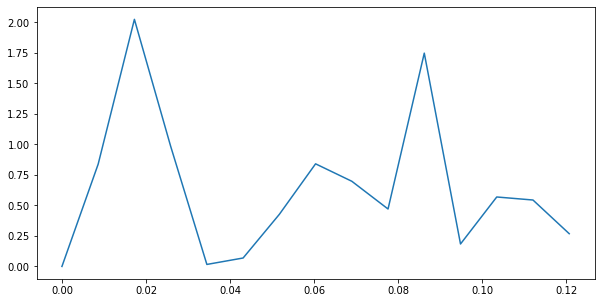

In [34]:
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)

In [35]:
print(type(Pxx.argmax()))
print(type(Pxx[0]))
f[2]

<class 'numpy.int64'>
<class 'numpy.float64'>


0.017241379310344827

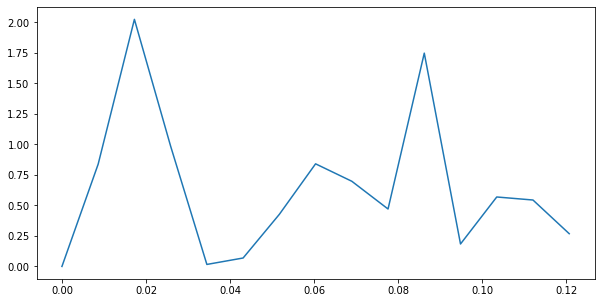

In [36]:
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)

In [37]:
scipy.stats.skew(obj_mag)

1.3982986513861562

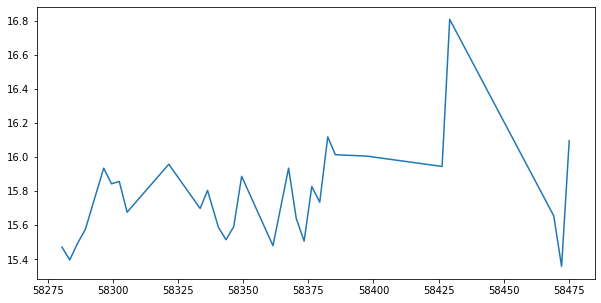

In [38]:
plt.figure(figsize=(10,5))
plt.plot(np.array(obj_mjd), np.array(obj_mag))

In [39]:
np.array(obj_mag).size

29

In [40]:
scipy.signal.spectrogram(np.array(obj_mag), fs=1.0/4.0, nperseg=np.array(obj_mag).size)

(array([0.        , 0.00862069, 0.01724138, 0.02586207, 0.03448276,
        0.04310345, 0.05172414, 0.06034483, 0.06896552, 0.07758621,
        0.0862069 , 0.09482759, 0.10344828, 0.11206897, 0.12068966]),
 array([58.]),
 array([[0.07133828],
        [1.22509693],
        [1.49204684],
        [0.67701684],
        [0.14637784],
        [0.03707635],
        [0.71527943],
        [1.03974186],
        [0.43332191],
        [0.18522758],
        [1.30973651],
        [0.2262271 ],
        [0.3064178 ],
        [0.53423888],
        [0.69662891]]))

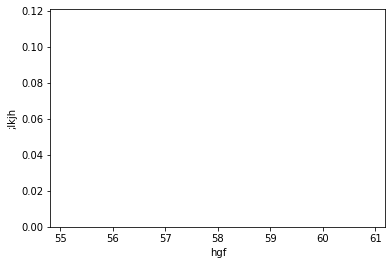

In [41]:
f, t, Sxx = scipy.signal.spectrogram(np.array(obj_mag), fs=1.0/4.0, nperseg=np.array(obj_mag).size)
plt.pcolormesh(t, f, Sxx)
plt.ylabel(';lkjh')
plt.xlabel('hgf')
plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.metrics import accuracy_score

In [5]:
data1 = pd.read_csv(r'prepared_data.csv')
data1.head()

,Unnamed: 0,obj_id,filter,mean_magn,amplitude,trand_angle,skew,std,max_PSD,max_fs,class
0,0,695111400064435,zg,15.773690,1.453001,0.001723,1.398299,0.289004,3.399184,0.010275,OTHER
1,1,696111300007125,zg,14.364000,2.814000,0.010997,-0.184409,0.831350,109.148506,0.004933,M
2,2,650116300021136,zg,13.844756,4.562000,0.014918,-0.331234,1.557293,389.605181,0.005218,M
3,3,739102400006782,zg,13.976114,3.712000,0.021147,-0.069805,1.090874,154.242913,0.005060,M
4,4,650112100009135,zg,15.054762,5.769000,-0.021382,-1.735134,1.443471,221.024325,0.006069,M


In [6]:
# data1=data.drop(['Unnamed: 0','obj_id'], axis=1)
data1=data1.drop(['filter','Unnamed: 0'], axis=1)

In [7]:
data1['class'].value_counts()

OTHER    7500
M        3224
RRAB     2373
EW       1999
LB       1553
EA       1427
SR       1396
UV        819
SRB       660
Name: class, dtype: int64

In [8]:
array = data1.values
X = array[:,0:7]
Y = array[:,7]
validation_size = 0.2
seed = 5
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
print(X)
# train.head()

[[695111400064435 15.773689697528708 1.4530010223388672 ...
  1.3982986513861562 0.2890036265553167 3.399183919624698]
 [696111300007125 14.364000009935957 2.814000129699707 ...
  -0.18440869844623625 0.8313498611121959 109.14850576063336]
 [650116300021136 13.844756033362412 4.562000274658203 ...
  -0.331234164467828 1.5572930114131476 389.60518065737955]
 ...
 [640112100011424 15.961218766868114 0.14300060272216794 ...
  0.14736075333151127 0.02294249993802439 0.02643602021909957]
 [640111400015183 12.599720910538075 0.4969997406005859 ...
  0.05206846571869729 0.12679510506948202 0.6155572290502526]
 [640103400028847 18.234931025011786 4.869001388549805 ...
  0.590790379035186 1.4966895771907496 456.0608294055748]]


In [ ]:
#Learning with XGB model
model = XGBClassifier(random_state=32, seed=3, colsample_bytree=0.6, subsample=0.6, n_estimators=1100)
model.fit(X_train,Y_train)
pred = model.predict(X_validation)
accuracy = accuracy_score(Y_validation, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# best filtration

In [ ]:
filters = []
for i in range(1000):
    resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=ra[i], dec=dec[i], r=5))
    
    try:
        res = resp.json()
        for i in res.keys():
            filters.append(res[i]['meta']['filter'])
            
    except Exception as ex:
        print("file {} has error".format(i), ex)

In [ ]:
# 1000 requests
Counter(filters)

In [ ]:
#### the length of averege response

In [ ]:
length = []
for i in range(1000):
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=ra[i],
                                                                                                                          dec=dec[i], 
                                                                                                                          r=5))

        res = resp.json()
        for i in res.keys():
            length.append( len(res[i]['lc']) )
            
    except Exception as ex:
        print("file {} has error".format(i), ex)

In [ ]:
length = np.array(length)

In [ ]:
length.mean()

In [ ]:
length.min()

In [ ]:
length.max()

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(length)

In [ ]:
# précédent

ra=[None]*54978
dec=[None]*54978
Num=[None]*54978 
for i in range(54977):
    Num[i]=data['NNo'][i]
    try:
        str1 = data['J2000.0'][i]
        ra[i] = str1[:9]
        dec[i] = str1[9:]
        ra[i] = hms_to_degrees(float(ra[i][:2]),float(ra[i][2:4]),float(ra[i][4:6]))
        dec[i] = dms_to_degrees(float(dec[i][:4]),float(dec[i][4:6]),float(dec[i][6:8]))
        if ra[i] > 360 or dec[i] > 360:
            ra[i].remove
            dec[i].remove
    except:
        pass #print('1')
        
ra = list(filter(None, ra))
dec = list(filter(None, dec))